<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/cokriging_gullfaks_poroseismic_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Co-kriging for Porosity from Seismic in R

## Install libraries

In [ ]:
install.packages("gstat")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘intervals’, ‘sp’, ‘zoo’, ‘spacetime’, ‘FNN’




In [ ]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("sp")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(gstat)
library(ggplot2)
library(sp)

## Load porosity top data

In [ ]:
filepath = "https://raw.githubusercontent.com/yohanesnuwara/geostatistics/main/results/Top%20Ness%20Porosity.txt"
download.file(filepath, destfile="/content/Top Ness porosity.txt", method="wget")

In [ ]:
# Define column names
colnames <- c("WELL", "UTMX", "UTMY", "AVGPOR")

# Read well tops data
portops <- read.table("/content/Top Ness porosity.txt", header=T, col.names=colnames)

print(head(portops, n=10))

   WELL     UTMX    UTMY    AVGPOR
1   A15 456660.8 6781496 0.1754247
2   A16 456516.2 6784064 0.2116439
3    B2 458442.8 6785840 0.2177148
4    B8 457789.3 6787190 0.1095598
5    B9 456713.5 6785544 0.1420700
6    C1 453155.8 6786788 0.1182995
7    C2 454840.0 6787607 0.1183212
8    C3 456410.2 6788725 0.1181895
9    C4 455024.1 6786211 0.1186238
10   C5 453582.3 6783002 0.1166883


In [ ]:
# Well name column
portops$WELL

[1] "A15" "A16" "B2"  "B8"  "B9"  "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"

## Load amplitude top data

In [ ]:
f1 = "https://raw.githubusercontent.com/yohanesnuwara/geostatistics/main/results/Ness_extracted_amplitude.txt"

download.file(f1, destfile="/content/Top Ness amplitude.txt", method="wget")

In [ ]:
colnames <- c("UTMX", "UTMY", "TWT", "AMP")
amptops <- read.table("Top Ness amplitude.txt", col.names=colnames)

print(tail(amptops, 10))

          UTMX    UTMY      TWT        AMP
38845 457046.3 6783625 1721.500 -5209.2613
38846 457021.3 6783626 1722.756 -4988.1199
38847 456471.4 6783633 1750.550   830.0522
38848 456496.4 6783633 1749.706  -530.7991
38849 456521.4 6783633 1747.465 -1449.3583
38850 456546.4 6783632 1745.225   202.6226
38851 456571.4 6783632 1742.984 -1726.7115
38852 456596.3 6783632 1740.744 -1081.3434
38853 456621.3 6783631 1738.504   411.7366
38854 456646.3 6783631 1736.263 -1128.8946


In [ ]:
# Remove NaNs in data
amptops <- amptops[complete.cases(amptops), ]

print(head(amptops, 10))

       UTMX    UTMY     TWT        AMP
50 453687.7 6780306 2010.79 -2528.5624
51 453700.2 6780305 2024.79  2013.7127
52 453712.7 6780305 2024.79  1790.7166
53 453725.2 6780305 2020.79   313.1070
54 453762.7 6780304 2020.79  1620.3771
55 453775.2 6780304 2016.79  1300.0781
56 453900.2 6780302 2017.79   666.6587
57 453912.7 6780302 2019.79  1030.5086
58 453925.2 6780302 2023.79  2200.9768
59 453975.2 6780302 2023.79 -1413.9375


## Plot

Scatter plot with native R

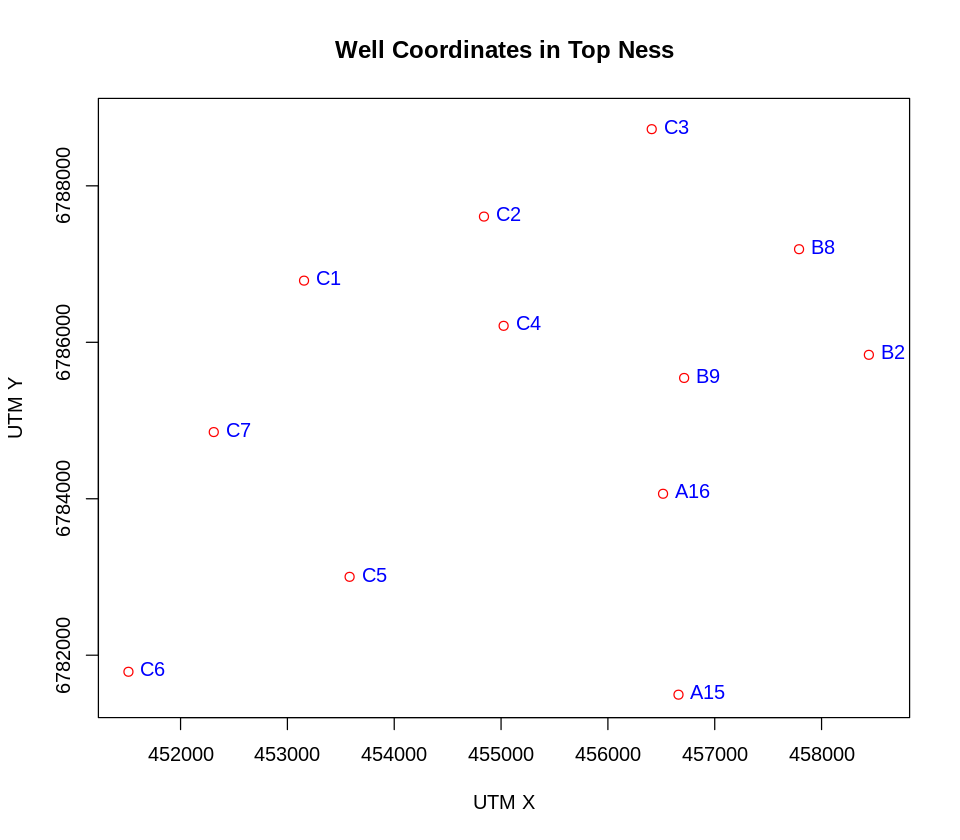

In [ ]:
# control size of figure
options(repr.plot.width=8, repr.plot.height=7)

# Scatter plot of all wells in the top structure
plot(portops$UTMX, portops$UTMY, xlab="UTM X", ylab="UTM Y", 
     main="Well Coordinates in Top Ness",
     pch=1, col="red", cex=1, # pch is point types, cex is point size
     xlim=c(min(portops$UTMX), max(portops$UTMX)+100),
     ylim=c(min(portops$UTMY), max(portops$UTMY)+100)) # + 100 so that "C3" is visible

# Annotate each point
text(portops$UTMX, portops$UTMY, labels=portops$WELL, pos=4, col="blue")

Scatter plot with ggplot2

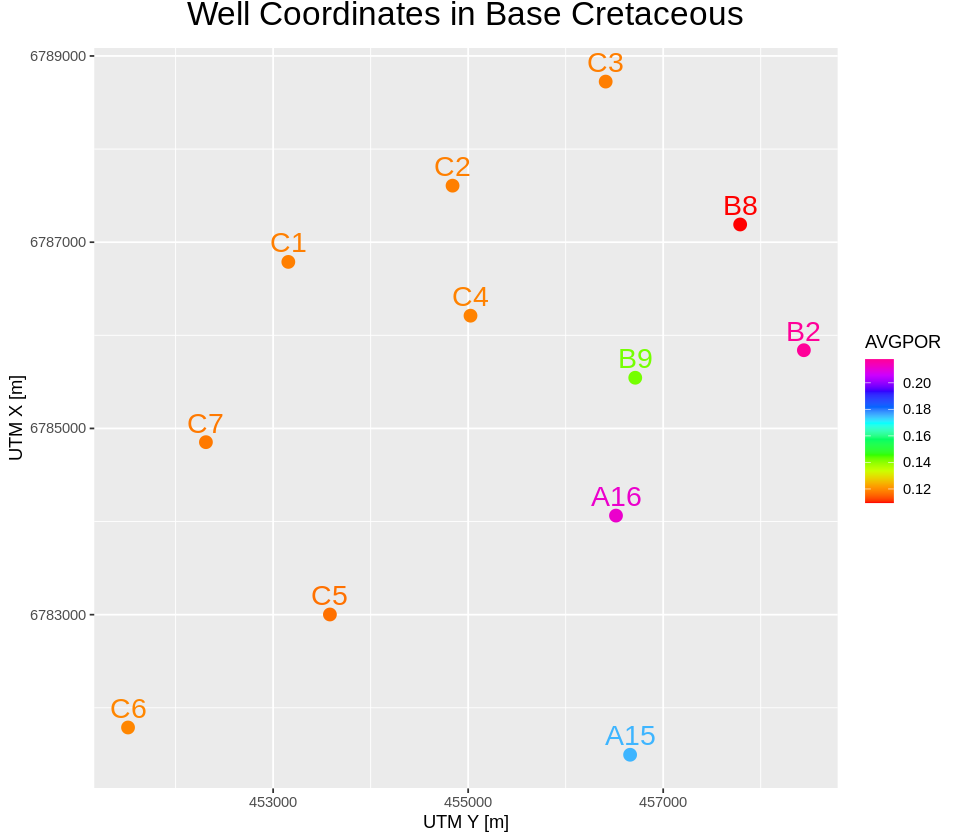

In [ ]:
# Scatter plot with ggplot2
p <- ggplot(portops, aes(UTMX, UTMY, color=AVGPOR, label=WELL)) +
     labs(y="UTM X [m]", x = "UTM Y [m]", title="Well Coordinates in Base Cretaceous") +
     theme(plot.title = element_text(hjust = 0.5, size=20, vjust=2)) +
     geom_point(size=5, shape=20) + # point size and style
     geom_text(size=6, vjust=-0.5) + # annotate points
     scale_color_gradientn(colours = rainbow(10))

print(p)

## Variogram analysis

### Well top data

In [ ]:
coordinates(portops)<-~UTMX+UTMY
pp<-gstat(id="AVGPOR", formula=AVGPOR~1, data=portops)


Two possible variogram models. Model 1:

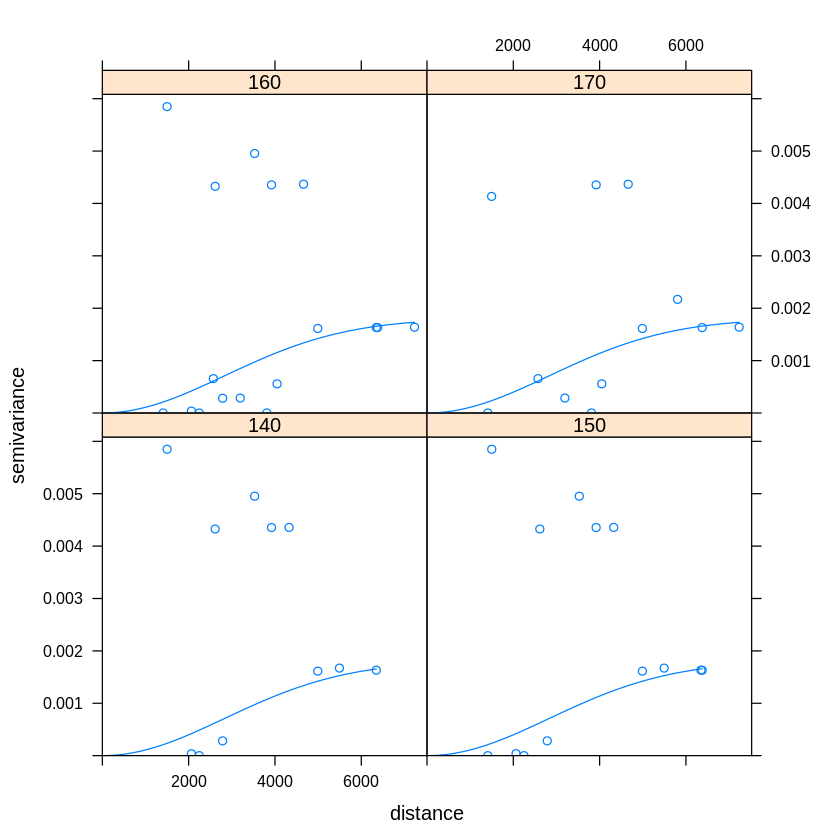

In [ ]:
portops.vv<-variogram(pp, cutoff=10000, width=20, alpha=c(140, 150, 160, 170))
portops.vm<-vgm(model="Gau", psill=0.0018, range=4000, nugget=0)

plot(portops.vv, model=portops.vm)

Model 2:

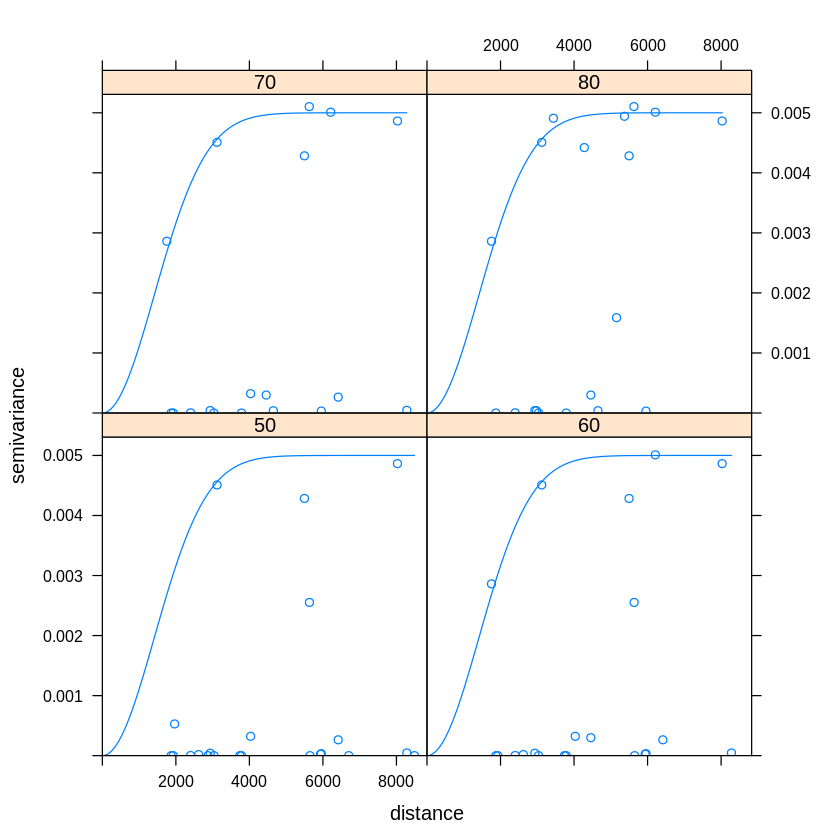

In [ ]:
portops.vv<-variogram(pp, cutoff=10000, width=20, alpha=c(50, 60, 70, 80))
portops.vm<-vgm(model="Gau", psill=0.005, range=2000, nugget=0)

plot(portops.vv, model=portops.vm)

Model 2 looks better, with direction of anisotropy 70 degrees.

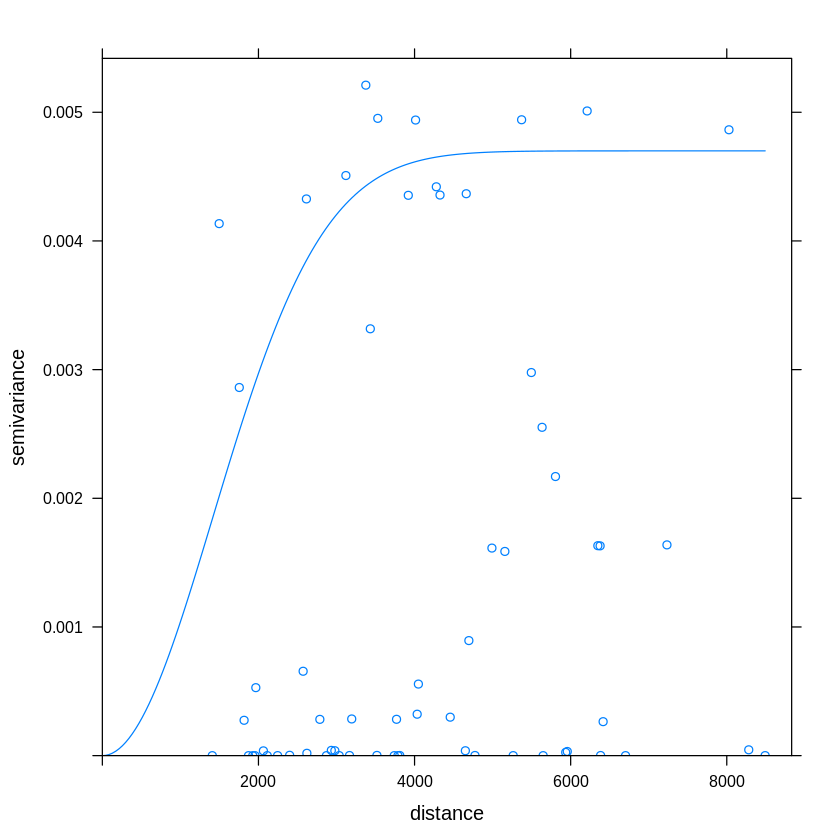

In [ ]:
portops.vv<-variogram(pp, cutoff=10000, width=20, alpha=70)
portops.vm<-vgm(model="Gau", psill=0.0047, range=2000, nugget=0)

plot(portops.vv, model=portops.vm)

### Seismic horizon time

In [ ]:
coordinates(amptops)<-~UTMX+UTMY
pp<-gstat(id="AMP", formula=AMP~1, data=amptops)


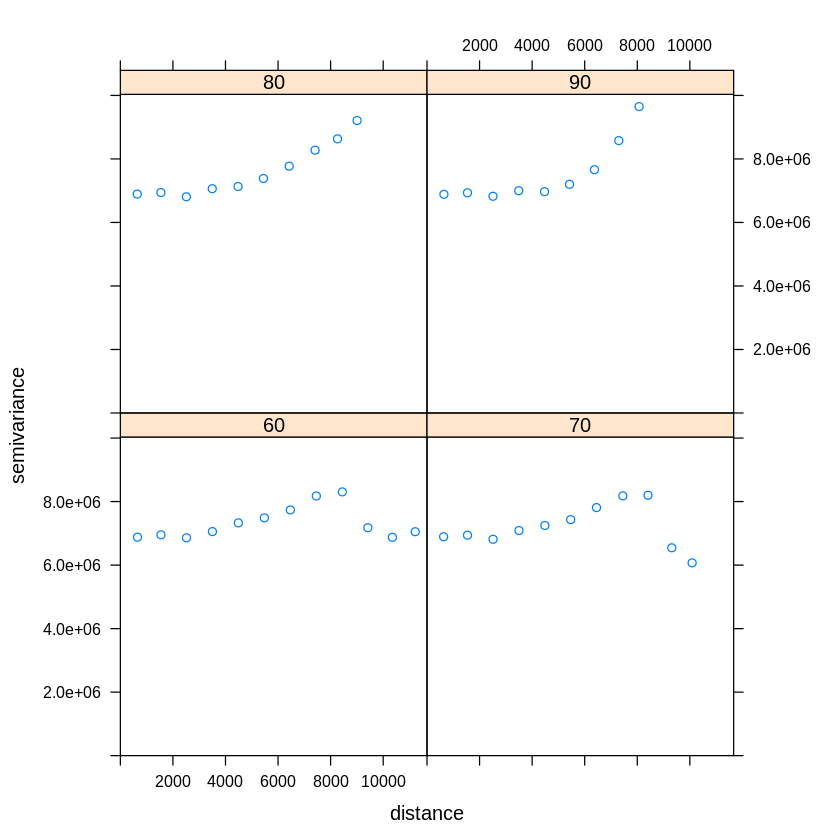

In [ ]:
# Plot variogram at various directions
# amptops.vv<-variogram(pp, cutoff=15000, alpha=c(0, 45, 90, 135))
amptops.vv<-variogram(pp, cutoff=15000, alpha=c(60, 70, 80, 90))

plot(amptops.vv)

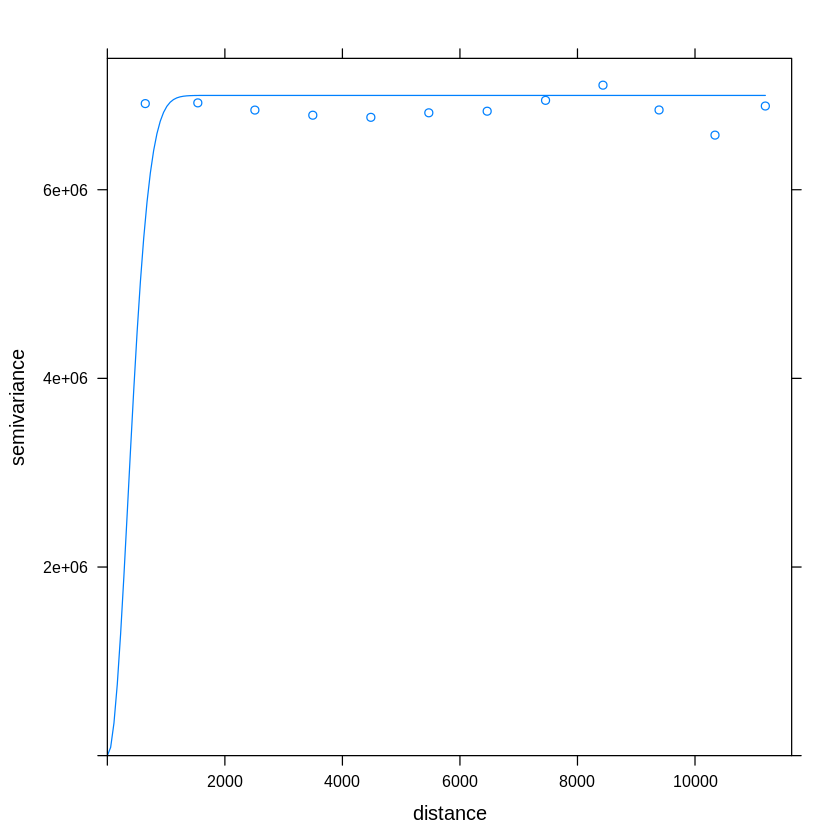

In [ ]:
amptops.vv<-variogram(pp, cutoff=15000, alpha=70)
amptops.vm<-vgm(model="Gau", psill=7e+6, range=500, nugget=0)

plot(amptops.vv, model=amptops.vm)

In [ ]:
seis_creta.vmf <- fit.variogram(seis_creta.vv, seis_creta.vm)
plot(seis_creta.vv, model=seis_creta.vmf)

ERROR: ignored

In [ ]:
print(seis_creta.vmf)

## Cross-variogram

Base cretaceous

In [ ]:
pp <- gstat(id="AVGPOR", formula=AVGPOR~1, data=portops)
pp <- gstat(pp, id="AMP", formula=AMP~1, data=amptops)

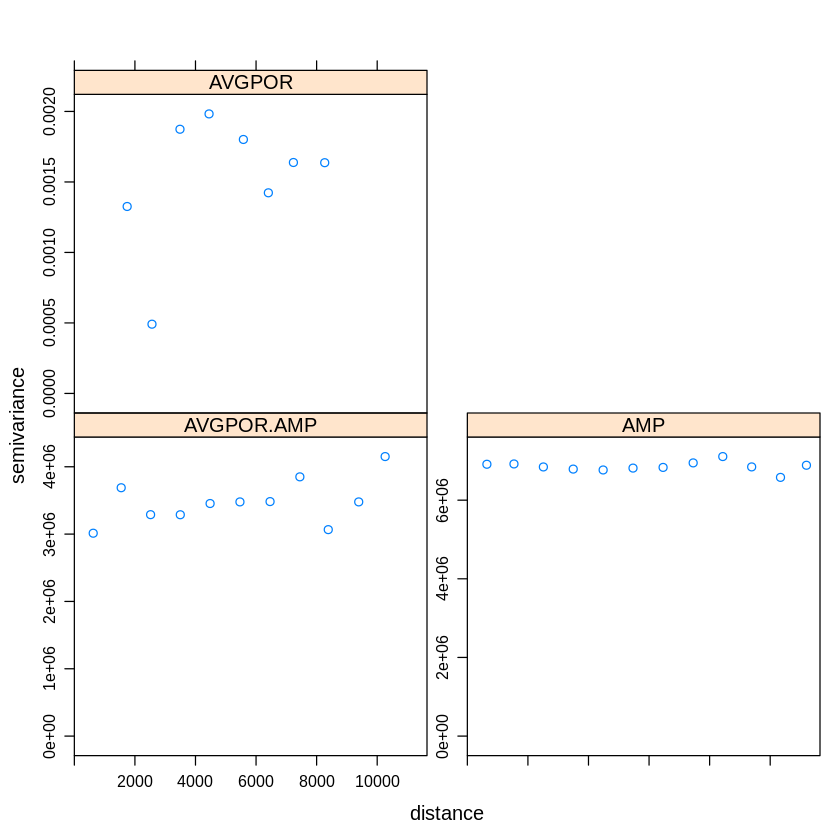

In [ ]:
crvv <- variogram(pp, cutoff=15000)

plot(crvv)

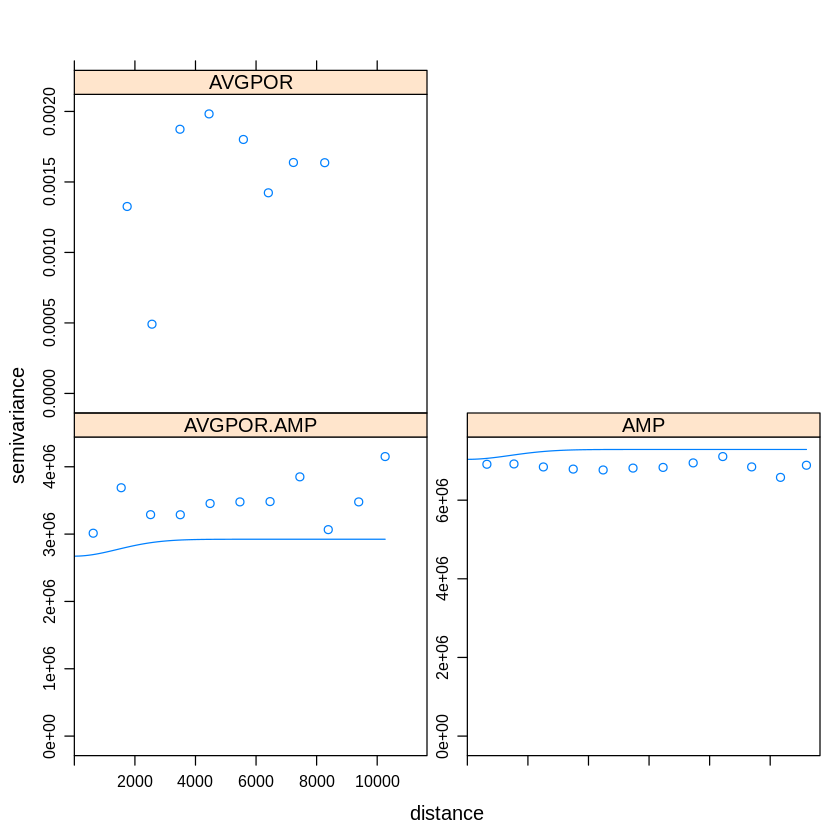

In [ ]:
pp<-gstat(pp, id="AVGPOR", model=portops.vm, fill.all=T)
pp<-fit.lmc(crvv, pp)

plot(crvv, model=pp)

Top Etive

In [ ]:
coordinates(well_etive)<-~UTMX+UTMY
coordinates(seis_etive)<-~UTMX+UTMY

In [ ]:
pp <- gstat(id="TVD", formula=TVD~1, data=well_etive)
pp <- gstat(pp, id="TWT", formula=TWT~1, data=seis_etive)

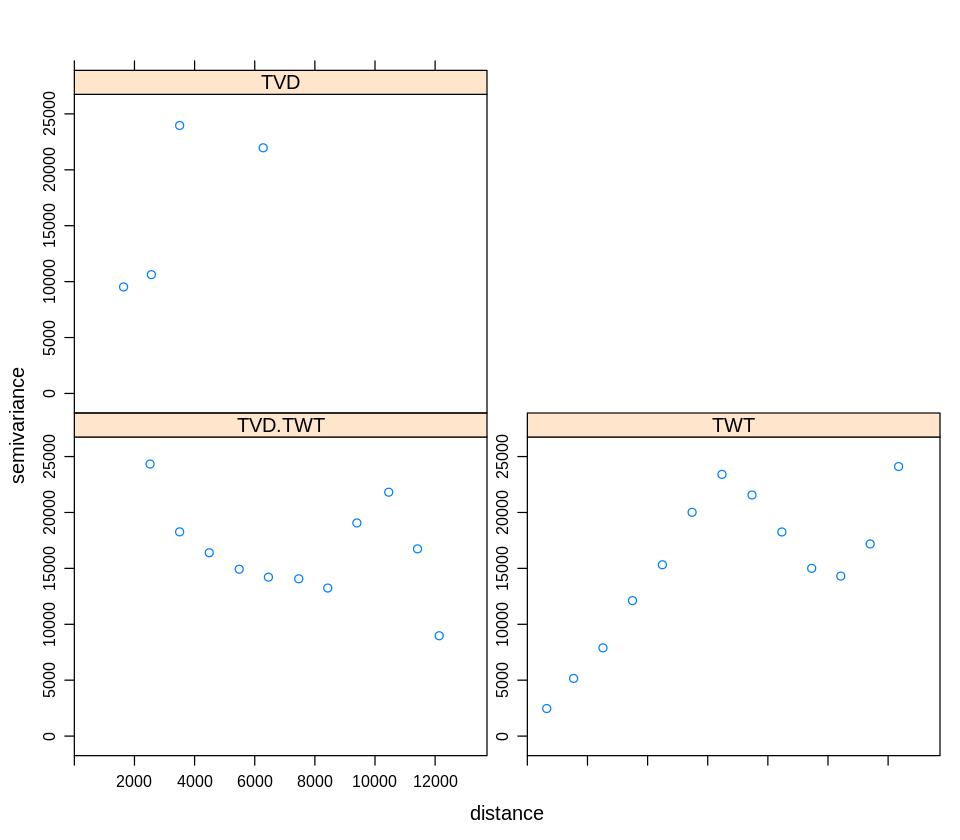

In [ ]:
crvv <- variogram(pp, cutoff=15000)

plot(crvv, ylim=c(0, 25000))

Top Ness

In [ ]:
coordinates(well_ness)<-~UTMX+UTMY
coordinates(seis_ness)<-~UTMX+UTMY

In [ ]:
pp <- gstat(id="TVD", formula=TVD~1, data=well_ness)
pp <- gstat(pp, id="TWT", formula=TWT~1, data=seis_ness)

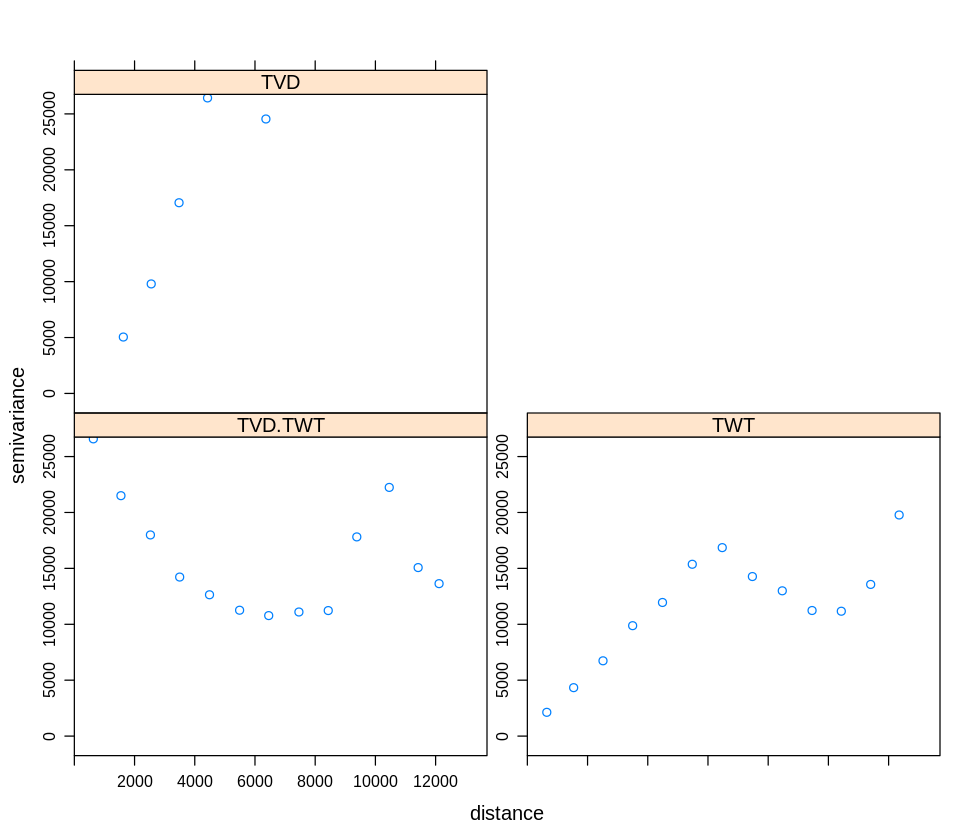

In [ ]:
crvv <- variogram(pp, cutoff=15000)

plot(crvv, ylim=c(0, 25000))

Top Tarbert

In [ ]:
coordinates(well_tarb)<-~UTMX+UTMY
coordinates(seis_tarb)<-~UTMX+UTMY

In [ ]:
pp <- gstat(id="TVD", formula=TVD~1, data=well_tarb)
pp <- gstat(pp, id="TWT", formula=TWT~1, data=seis_tarb)

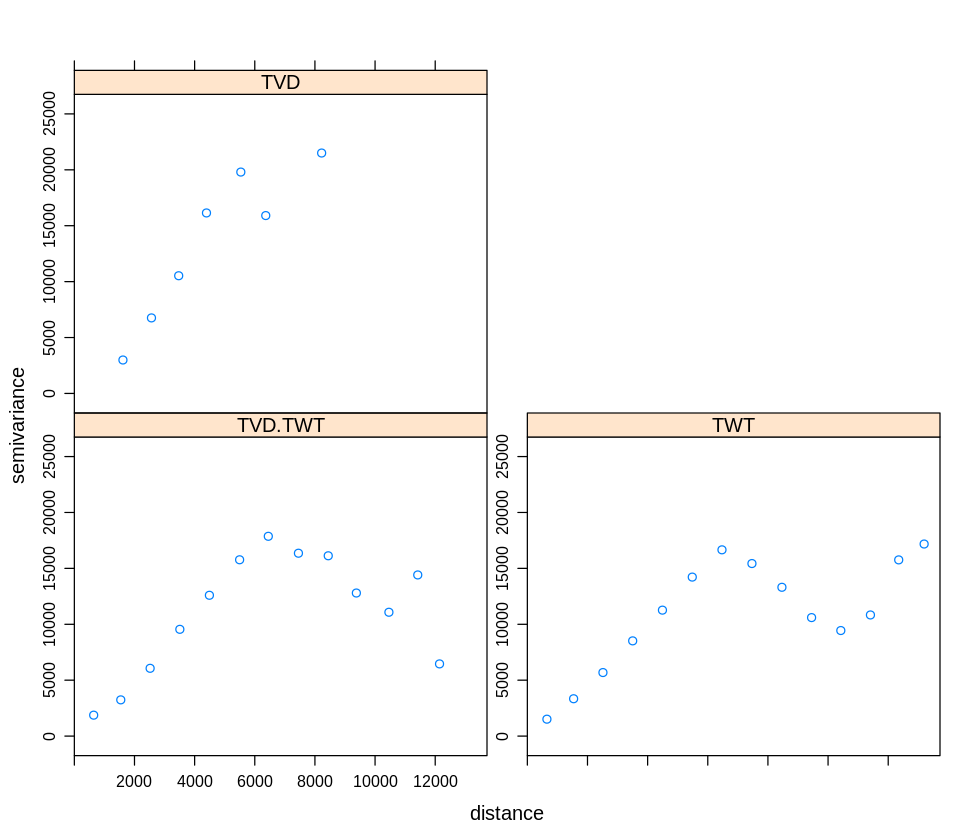

In [ ]:
crvv <- variogram(pp, cutoff=15000)

plot(crvv, ylim=c(0, 25000))

## Co-kriging

In [ ]:
print(pp)

data:
TVD : formula = TVD`~`1 ; data dim = 13 x 11
TWT : formula = TWT`~`1 ; data dim = 103768 x 3
variograms:
           model      psill range
TVD[1]       Nug   331.6682     0
TVD[2]       Gau 12036.6735  4000
TWT[1]       Nug   672.9146     0
TWT[2]       Gau 10755.3773  4000
TVD.TWT[1]   Nug   472.4239     0
TVD.TWT[2]   Gau 10306.9356  4000


In [ ]:
minx = min(portops$UTMX)
maxx = max(portops$UTMX)
miny = min(portops$UTMY)
maxy = max(portops$UTMY)

xx<-seq(from=minx, to=maxx, by=100)
yy<-seq(from=miny, to=maxy, by=100)
xy<-expand.grid(x=xx,y=yy)
coordinates(xy)<- ~ x+y
gridded(xy)<-T

In [ ]:
456000, 458000
6782000, 6785000

In [ ]:
minx = 456000
maxx = 458000
miny = 6782000
maxy = 6785000

xx<-seq(from=minx, to=maxx, by=100)
yy<-seq(from=miny, to=maxy, by=100)
xy<-expand.grid(x=xx,y=yy)
coordinates(xy)<- ~ x+y
gridded(xy)<-T

In [ ]:
print(pp)

data:
TVD : formula = TVD`~`1 ; data dim = 13 x 11
TWT : formula = TWT`~`1 ; data dim = 103768 x 3
variograms:
           model      psill range
TVD[1]       Nug   331.6682     0
TVD[2]       Gau 12036.6735  4000
TWT[1]       Nug   672.9146     0
TWT[2]       Gau 10755.3773  4000
TVD.TWT[1]   Nug   472.4239     0
TVD.TWT[2]   Gau 10306.9356  4000


In [ ]:
pp$set=list(nocheck=1)
cokr <- predict(pp, xy)

In [ ]:
print(cokr)

ERROR: ignored